Configuration du chemin Python

Elle ajoute un chemin personnalisé à sys.path afin de permettre l’import de packages Python installés localement.

In [1]:
import sys
sys.path.append("/fast/fouatirou/python-packages")

Imports principaux et configuration globale

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torchvision import transforms
from datasets import load_dataset   # HuggingFace datasets
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import editdistance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Where to store checkpoints, logs, etc.
BASE_DIR = "/fast/fouatirou/rimes_crnn"
CHECKPOINT_DIR = os.path.join(BASE_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print("Checkpoint dir:", CHECKPOINT_DIR)

Device: cuda
Checkpoint dir: /fast/fouatirou/rimes_crnn/checkpoints


Chargement du dataset RIMES

In [3]:
import os
from datasets import load_dataset

BASE_DIR = "/fast/fouatirou/rimes_crnn"
HF_CACHE_DIR = os.path.join(BASE_DIR, "hf_cache")
os.makedirs(HF_CACHE_DIR, exist_ok=True)

ds = load_dataset("Teklia/RIMES-2011-line", cache_dir=HF_CACHE_DIR)
print(ds)
print("Train:", len(ds["train"]), "Val:", len(ds["validation"]), "Test:", len(ds["test"]))


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 10188
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 1138
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 778
    })
})
Train: 10188 Val: 1138 Test: 778


Vocabulaire et Dataset personnalisé

Cette partie définit tous les caractères que le modèle est autorisé à prédire.
Elle inclut les lettres minuscules et majuscules, les caractères accentués du français, les chiffres et quelques signes de ponctuation.

Tout caractère absent de ce vocabulaire sera ignoré pendant l’entraînement et l’inférence.

Elle implémente un Dataset PyTorch personnalisé qui charge les images manuscrites, les redimensionne à une hauteur fixe tout en conservant une largeur variable, et convertit les transcriptions textuelles en séquences d’indices numériques compatibles avec l’entraînement CTC.

In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch

# ===== Vocabulary =====
vocab = list(
    "abcdefghijklmnopqrstuvwxyzàâéèêëîôûùüç"
    "ABCDEFGHIJKLMNOPQRSTUVWXYZÀÂÉÈÊËÎÔÛÙÜÇ"
    "0123456789.,!? '"
)
char2idx = {ch: i + 1 for i, ch in enumerate(vocab)}  # 0 reserved for CTC blank
idx2char = {i + 1: ch for i, ch in enumerate(vocab)}

print("Vocabulary size:", len(vocab), "+ 1 blank →", len(vocab) + 1, "classes")

# ===== Dataset wrapper =====
class RIMESDataset(Dataset):
    def __init__(self, hf_dataset_split, char2idx, transform=None, img_height=128):
        self.split = hf_dataset_split
        self.char2idx = char2idx
        self.transform = transform
        self.img_height = img_height

    def __len__(self):
        return len(self.split)

    def __getitem__(self, idx):
        item = self.split[idx]
        img = item["image"].convert("L")  # grayscale

        # resize to fixed height while keeping aspect ratio
        w, h = img.size
        new_h = self.img_height
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        if self.transform is not None:
            img = self.transform(img)

        text = item["text"]
        encoded = [self.char2idx[ch] for ch in text if ch in self.char2idx]
        label_tensor = torch.tensor(encoded, dtype=torch.long)

        return img, label_tensor


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

img_height = 128


Vocabulary size: 92 + 1 blank → 93 classes


Padding dynamique

Cette cellule définit une fonction collate_fn qui pad les images en largeur afin de gérer des tailles variables.
Elle crée ensuite les DataLoader pour le train, la validation et le test avec batching et parallélisation.

In [5]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

def collate_fn_pad(batch):
    imgs, labels = zip(*batch)
    max_w = max(img.shape[2] for img in imgs)
    padded_imgs = []
    for img in imgs:
        c, h, w = img.shape
        pad_w = max_w - w
        if pad_w > 0:
            img = F.pad(img, (0, pad_w, 0, 0), value=0.0)
        padded_imgs.append(img)
    imgs_tensor = torch.stack(padded_imgs)
    return imgs_tensor, list(labels)

batch_size = 32  

train_dataset = RIMESDataset(ds["train"],      char2idx, transform, img_height)
val_dataset   = RIMESDataset(ds["validation"], char2idx, transform, img_height)
test_dataset  = RIMESDataset(ds["test"],       char2idx, transform, img_height)

print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn_pad, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          collate_fn=collate_fn_pad, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          collate_fn=collate_fn_pad, num_workers=4, pin_memory=True)


Train: 10188 Val: 1138 Test: 778


Décodage CTC (greedy decoding)

Cette fonction transforme les sorties du modèle (log-probabilités CTC) en texte lisible.
Elle supprime les doublons successifs et les symboles blank, conformément au principe du décodage CTC.

In [6]:
import torch

def decode_prediction(output, idx2char):
    """
    output: (batch, T, n_classes) log-softmax scores
    idx2char: dict {index -> char}, 0 is CTC blank
    """
    batch_size, time_steps, n_classes = output.size()
    _, pred_idxs = torch.max(output, dim=2)  # [B,T]

    results = []
    for b in range(batch_size):
        preds = pred_idxs[b].cpu().tolist()
        prev = None
        chars = []
        for idx in preds:
            if idx != prev and idx != 0:
                chars.append(idx2char.get(idx, ""))
            prev = idx
        results.append("".join(chars))
    return results


Définition du modèle CRNNv2

Cette cellule définit l’architecture CRNNv2, composée d’un CNN pour l’extraction de caractéristiques et d’un LSTM bidirectionnel.
Le modèle réduit la hauteur de l’image et conserve l’axe temporel pour la reconnaissance de texte ligne par ligne.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CRNNv2(nn.Module):
    """
    Slightly deeper & faster CRNN:
    - more conv blocks (better features)
    - more downsampling in height (smaller LSTM input)
    - same time axis reduction (W // 4) so training loop stays the same
    """
    def __init__(self, img_height, n_channels, n_classes):
        super(CRNNv2, self).__init__()

        self.cnn = nn.Sequential(
            # Block 1: 128xW -> 64xW/2
            nn.Conv2d(n_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Block 2: 64xW/2 -> 32xW/4
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Block 3: 32xW/4 -> 16xW/4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d((2, 1)),

            # Block 4: 16xW/4 -> 8xW/4
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d((2, 1)),
        )

        # after these pools, height = img_height / 16  (128 -> 8)
        conv_height = img_height // 16
        self.conv_height = conv_height
        self.rnn_input_size = 256 * conv_height

        self.dropout = nn.Dropout(0.3)

        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.3,
        )

        self.fc = nn.Linear(256 * 2, n_classes)

    def forward(self, x):
        # x: [B,1,H,W]
        conv = self.cnn(x)           # [B,C,H',W'] with H'=8, W'=W//4
        conv = self.dropout(conv)
        b, c, h, w = conv.size()     

       
        conv = conv.permute(0, 3, 1, 2)   # [B,W',C,H']
        conv = conv.reshape(b, w, c * h)  # [B,T, C*H] = [B,T, rnn_input_size]

        rnn_out, _ = self.rnn(conv)      # [B,T,512]
        out = self.fc(rnn_out)           # [B,T,n_classes]
        out = out.log_softmax(2)         # CTC expects log-probs

        return out


Fonction d’évaluation CER / WER

Cette fonction calcule le Character Error Rate (CER) et le Word Error Rate (WER) sur un DataLoader.
Elle est utilisée pour évaluer objectivement la qualité de reconnaissance du modèle.

In [8]:
import editdistance
import torch

@torch.no_grad()
def evaluate_loader(loader, model, idx2char, device, max_batches=None):
    """
    Compute CTC CER / WER over a DataLoader.
    - loader: train_loader or val_loader
    - model:  your CRNN or CRNNv2
    - idx2char: dict index -> char (0 is blank)
    - device: torch.device("cuda" or "cpu")
    - max_batches: if not None, limit number of batches (for speed)
    """
    model.eval()
    total_char_edits = 0
    total_chars      = 0
    total_word_edits = 0
    total_words      = 0

    for batch_idx, (imgs, labels_list) in enumerate(loader, start=1):
        if max_batches is not None and batch_idx > max_batches:
            break

        imgs = imgs.to(device)
        outputs = model(imgs)  # [B,T,C] log-softmax
        pred_texts = decode_prediction(outputs, idx2char)

        # ground truth texts
        truth_texts = [
            ''.join(idx2char[idx.item()] for idx in lbl)
            for lbl in labels_list
        ]

        for pred, truth in zip(pred_texts, truth_texts):
            # CER
            total_char_edits += editdistance.eval(list(pred), list(truth))
            total_chars      += len(truth)

            # WER
            truth_words = truth.split()
            total_word_edits += editdistance.eval(pred.split(), truth_words)
            total_words      += len(truth_words)

    cer = total_char_edits / max(1, total_chars)
    wer = total_word_edits / max(1, total_words)
    return cer, wer


Chargement d’un modèle entraîné et visualisation

Ici, un checkpoint sauvegardé est chargé dans un modèle CRNNv2.
Le modèle est utilisé pour prédire du texte sur un batch de test et afficher les images avec CER et WER.

Loading checkpoint: /fast/fouatirou/rimes_crnn/checkpoints/best_model_metrics.pt
Model loaded from epoch: 27
Val loss at that time: 0.45766587886545396
TEST CER: 8.92%  |  TEST WER: 32.86%
Best checkpoint epoch: 27


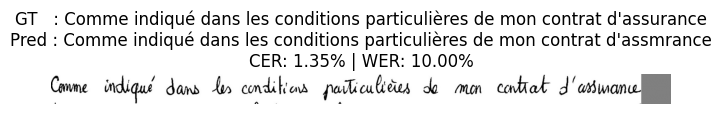

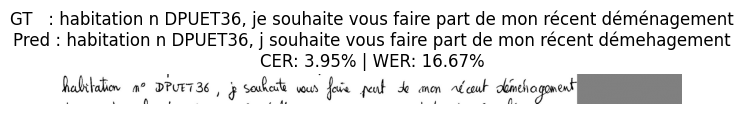

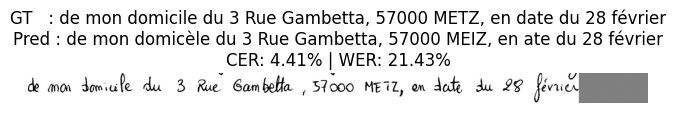

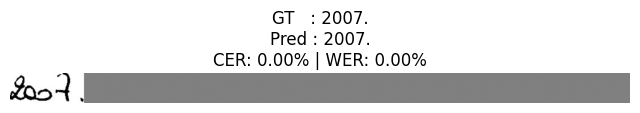

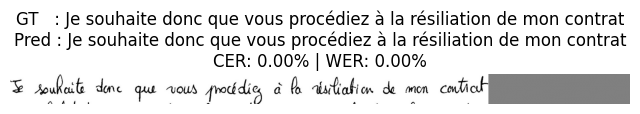

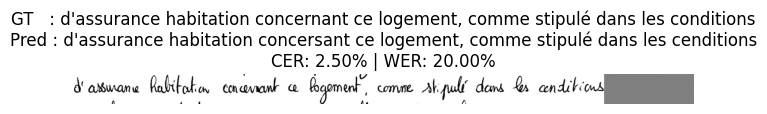

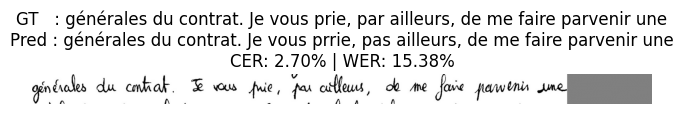

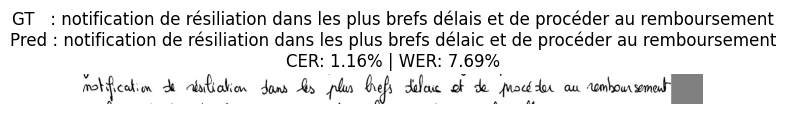

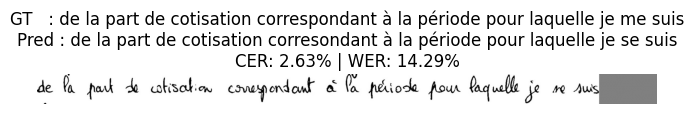

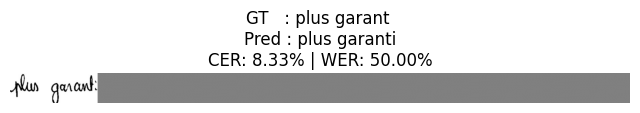

In [9]:
import matplotlib.pyplot as plt
import editdistance

# === Build model + load checkpoint ===
n_channels = 1
n_classes  = len(vocab) + 1

model = CRNNv2(img_height, n_channels, n_classes).to(device)

checkpoint_path = "/fast/fouatirou/rimes_crnn/checkpoints/best_model_metrics.pt"
print("Loading checkpoint:", checkpoint_path)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

print("Model loaded from epoch:", checkpoint.get("epoch", "unknown"))
print("Val loss at that time:", checkpoint.get("val_loss", "N/A"))

test_cer, test_wer = evaluate_loader(test_loader, model, idx2char, device)
print(f"TEST CER: {test_cer*100:.2f}%  |  TEST WER: {test_wer*100:.2f}%")
print("Best checkpoint epoch:", checkpoint.get("epoch", "unknown"))

# === Take one batch from test loader and show predictions ===
loader_to_test = test_loader

imgs_tensor, labels_list = next(iter(loader_to_test))
imgs_tensor = imgs_tensor.to(device)

with torch.no_grad():
    outputs = model(imgs_tensor)   # (batch, T, C)

pred_texts = decode_prediction(outputs, idx2char)

# Ground truth
truth_texts = [
    ''.join(idx2char[idx.item()] for idx in lbl)
    for lbl in labels_list
]

num_examples = min(10, len(pred_texts))

for i in range(num_examples):
    img = imgs_tensor[i].detach().cpu().numpy()  # (1,H,W)
    if img.ndim == 3 and img.shape[0] == 1:
        img = img[0]

    pred = pred_texts[i]
    truth = truth_texts[i]

    # CER
    cer = editdistance.eval(list(pred), list(truth)) / len(truth) if len(truth) > 0 else 0.0
    # WER
    truth_words = truth.split()
    wer = editdistance.eval(pred.split(), truth_words) / len(truth_words) if len(truth_words) > 0 else 0.0

    plt.figure(figsize=(8, 3))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(
        f"GT   : {truth}\n"
        f"Pred : {pred}\n"
        f"CER: {cer*100:.2f}% | WER: {wer*100:.2f}%"
    )
    plt.show()


Prétraitement d’images manuscrites

Cette cellule implémente tout le pipeline de prétraitement : binarisation, détection de ligne, recadrage et redimensionnement.
Elle garantit que les images d’entrée ont le même format que celles utilisées à l’entraînement.

In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

# ---- config ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_height = 128


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def _preprocess_from_gray(gray, img_height=128):
    """
    Core logic: take a GRAYSCALE image (numpy 2D),
    find main line via CCs, crop it, binarize, resize to 128 height,
    return (tensor_for_model, PIL_image_for_display).
    """

    # ---------- 1) find line with connected components ----------
    norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    th = cv2.adaptiveThreshold(
        norm, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,   # text becomes white, bg black for CC
        35, 15
    )

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th, 8)

    comps = []
    H, W = gray.shape

    for i in range(1, num_labels):        # skip background
        x, y, w, h, area = stats[i]
        if area < 200:                    # ignore tiny stuff
            continue
        if w / (h + 1e-6) < 0.4:          # ignore very vertical blobs
            continue
        comps.append((x, y, w, h))

    if len(comps) == 0:
        # fallback: whole image
        x0, y0, x1, y1 = 0, 0, W, H
    else:
        # group components that lie on the main text line
        ys = [y + h/2 for x, y, w, h in comps]
        med = np.median(ys)
        line_comps = [(x, y, w, h) for x, y, w, h in comps if abs((y + h/2) - med) < 40]
        if not line_comps:
            line_comps = comps

        xs  = [x     for x, y, w, h in line_comps]
        ys0 = [y     for x, y, w, h in line_comps]
        xe  = [x + w for x, y, w, h in line_comps]
        ye  = [y + h for x, y, w, h in line_comps]

        x0, y0, x1, y1 = min(xs), min(ys0), max(xe), max(ye)
        # padding
        x0, y0 = max(0, x0 - 20), max(0, y0 - 20)
        x1, y1 = min(W, x1 + 20), min(H, y1 + 20)

    cropped = gray[y0:y1, x0:x1]

    # ---------- 2) BINARIZE (black text on white) ----------
    cropped_norm = cv2.normalize(cropped, None, 0, 255, cv2.NORM_MINMAX)
    _, cropped_bw = cv2.threshold(
        cropped_norm, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    # background = 255, text = 0
    line_for_model = cropped_bw

    # ---------- 3) resize to height = img_height ----------
    h, w = line_for_model.shape
    new_w = int(w * (img_height / h))
    resized = cv2.resize(
        line_for_model,
        (new_w, img_height),
        interpolation=cv2.INTER_LANCZOS4
    )

    pil_img = Image.fromarray(resized)
    tensor = transform(pil_img).unsqueeze(0)  # (1,1,H,W)
    return tensor.to(device), pil_img


def preprocess_for_rimes_path(path, img_height=128, debug=False):
  
    bgr = cv2.imread(path)
    if bgr is None:
        raise ValueError("Image not found: " + str(path))
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    tensor, pil_img = _preprocess_from_gray(gray, img_height=img_height)

    if debug:
        plt.imshow(pil_img, cmap='gray')
        plt.axis('off')
        plt.title("Preprocessed line for model")
        plt.show()

    return tensor, pil_img


def preprocess_for_rimes_bgr(bgr, img_height=128, debug=False):
   
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    tensor, pil_img = _preprocess_from_gray(gray, img_height=img_height)

    if debug:
        plt.imshow(pil_img, cmap='gray')
        plt.axis('off')
        plt.title("Preprocessed line for model (upload)")
        plt.show()

    return tensor, pil_img


Interface d’upload et prédiction interactive

Cette cellule crée une interface interactive permettant d’uploader des images manuscrites.
Chaque image est prétraitée, affichée et transcrite automatiquement par le modèle entraîné.

In [12]:

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from ipywidgets import FileUpload, VBox, Output
from IPython.display import display



out = Output()
uploader = FileUpload(accept='image/*', multiple=True)

def on_upload_change(change):
   
    with out:
        print("\n=== New upload event ===")
        files = uploader.value

        if not files:
            print("No files in uploader.value")
            return

     
        if isinstance(files, dict):
            iterable = [(name, info) for name, info in files.items()]
        else:
            iterable = []
            for f in files:
                name = f.get("name") or f.get("metadata", {}).get("name", "uploaded_image")
                iterable.append((name, f))

        for name, file_info in iterable:
            print(f"\n----- File: {name} -----")
            try:
                bytes_data = file_info["content"]
                print(" - Bytes size:", len(bytes_data))

                # decode bytes to BGR image (OpenCV)
                img_array = np.frombuffer(bytes_data, np.uint8)
                bgr = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
                if bgr is None:
                    print(" !! Could not decode image with cv2.imdecode")
                    continue

                # preprocess (show preprocessed line)
                tensor, visu = preprocess_for_rimes_bgr(bgr, img_height=img_height, debug=True)
                print(" - Tensor shape:", tuple(tensor.shape))

                # predict
                model.to(device)
                model.eval()
                with torch.no_grad():
                    logits = model(tensor)   # (1, T, C)
                pred_text = decode_prediction(logits, idx2char)[0]

                print("Prediction:", pred_text)

            except Exception as e:
                print(" !! Error during processing:")
                print(repr(e))

# (re)connect callback
uploader.observe(on_upload_change, names='value')

display(VBox([uploader, out]))
